In [6]:
import matplotlib.pyplot as plt  # noqa
import numpy as np
import torch  # noqa

from neural_tokenizers.mistral_segmenter import MistralSegmenter
from neural_tokenizers.utils import pool_segments_by_lengths

segmenter = MistralSegmenter.from_path("mideind/bytemistral-isl-60m")

In [4]:
segmentation = segmenter.segment_string("Hér er ég í byrjun.")

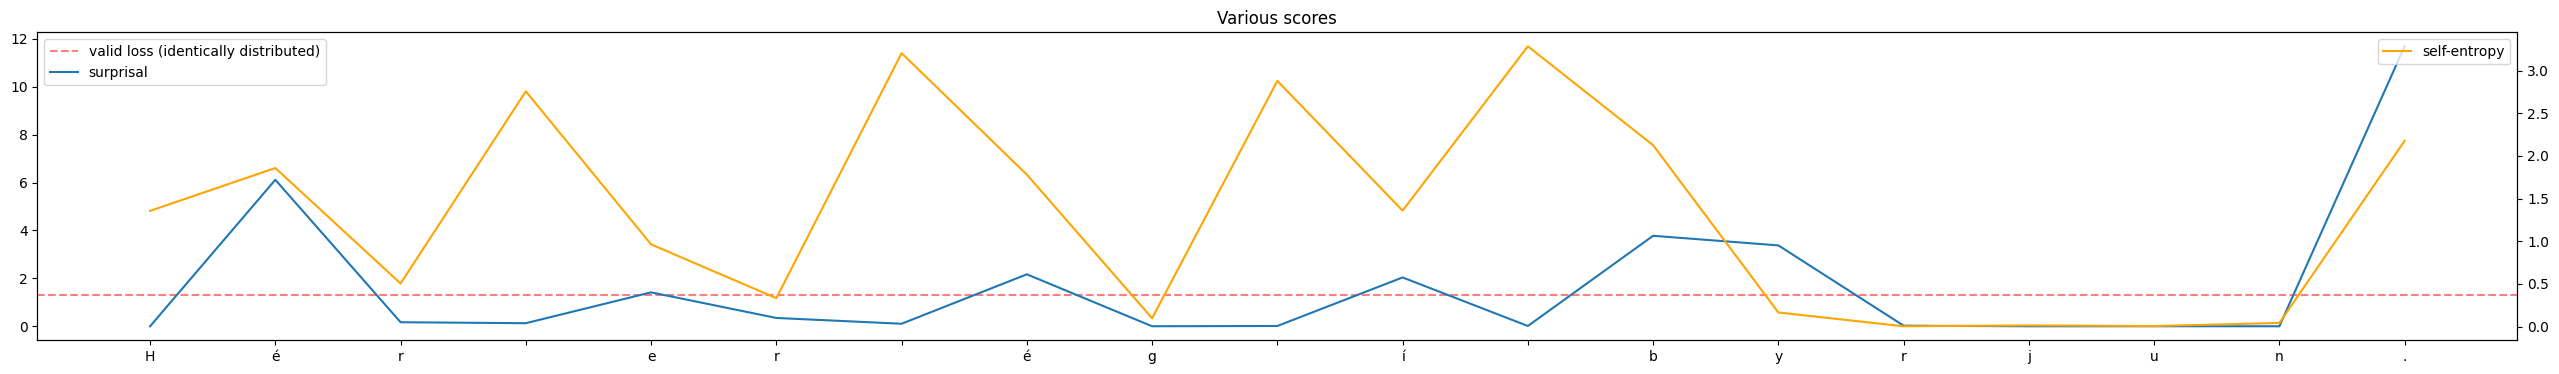

In [21]:
char_surprisals = (
    pool_segments_by_lengths(
        # ∷ (B × L) → (B × L × 1)
        hidden_state=segmentation.byte_surprisals.unsqueeze(-1),
        segment_lengths=segmentation.char_lens,
        reduction="max",
    )
    .squeeze(-1)
    .numpy()[0]
)

char_entropies = (
    pool_segments_by_lengths(
        segmentation.byte_entropies.unsqueeze(-1),
        segmentation.char_lens,
        reduction="max",
    )
    .squeeze(-1)
    .numpy()[0]
)

char_sequence = segmentation.chars
char_positions = np.arange(len(segmentation.chars))
char_surprisals = char_surprisals
char_entropies = char_entropies

# figure size, if string gets truncated make it bigger
plt.figure(figsize=(32, 4))

plt.axhline(y=1.320, color="r", linestyle="--", label="valid loss (identically distributed)", alpha=0.5)  # noqa
plt.plot(char_positions, char_surprisals, label="surprisal")
plt.legend()

# use separate axis for entropy
ax2 = plt.twinx()
ax2.plot(char_positions, char_entropies, label="self-entropy", color="orange")

plt.xticks(char_positions, char_sequence)

plt.title("Various scores")
plt.legend()
plt.show()
